<style>div.container { width: 100% }</style>
<img style="float:left;  vertical-align:text-bottom;" height="65" width="172" src="../assets/holoviz-logo-unstacked.svg" />
<div style="float:right; vertical-align:text-bottom;"><h2>Tutorial 3. Composing Plots</h2></div>

So far we have generated plots using [hvPlot](http://hvplot.pyviz.org), but we haven't discussed what exactly these plots are and how they differ from the output of other libraries offering the `.plot` API. Here we will see that the `.hvplot()` output is actually a rich, composable and compositional object that can be used in many different ways, not just as an immediate plot.  Specifically, hvPlot generates [HoloViews](https://holoviews.org) objects rendered using the [Bokeh](https://bokeh.org) backend so that they support interactive hovering, panning, and zooming. 

In this notebook, we'll examine the output of hvPlot calls to take a look at individual HoloViews objects. Then we will see how these "elements" offer us powerful ways of combining and composing layered visualizations.

### Read in the data

We'll read in the data as before, and also reindex by time so that we can more easily do resampling. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
%%time
df = pd.read_parquet('data/earthquakes.parq')
df.time = df.time.astype('datetime64[ns]')
df = df.set_index(df.time)

Wall time: 309 ms


### Composing plots
In this section we'll start looking at how we can group plots to gain a deeper understanding of the data. We'll start by resampling the data to explore patterns in number and magnitude of earthquakes over time. 

In [33]:
import hvplot.pandas  # noqa: adds hvplot method to pandas objects

In [4]:
weekly_count = df.id.resample('1W').count().rename('count')
weekly_count_plot = weekly_count.hvplot(title='weekly count')

The first thing to note is that with `hvplot`, it is common to grab a handle on the returned output, which isn't necessarily displayed right away. The value returned from the Matplotlib based `.plot` API of Pandas is an axis object that is typically discarded, with plotting display occurring only as a side effect if `%matplotlib inline` is loaded. With hvPlot, there are no side effects; the plot is displayed only if it is returned as the last value in the Jupyter cell (and thus no plot is visible in the above cell's output). hvPlot objects thus work like any other normal Python object; just as you don't expect `x=2` to display anything, `x=df.hvplot()` will not display anything; both just assign a value to `x`.

Once you have a handle on it, however, you can plot it if you wish to:

In [5]:
weekly_count_plot

:Curve   [time]   (count)

But we can also do other things, such as look at its textual representation by printing it:

In [6]:
print(weekly_count_plot)

:Curve   [time]   (count)


"`:Curve   [time]   (count)`" is HoloViews notation for saying that this object is a `Curve` element with `time` as a key dimension (`kdim`, in square brackets) and `count` as a value dimension (`vdim`, in parentheses). In other contexts, key dimensions are also called index dimensions or independent variables, while value dimensions are also called dependent variables. HoloViews will be discussed in more detail in a [later section](./07_Custom_Interactivity.ipynb).

Now let's do a similar resampling, but for magnitude:

In [7]:
weekly_mean_magnitude = df.mag.resample('1W').mean()
weekly_mean_magnitude_plot = weekly_mean_magnitude.hvplot(title='weekly mean magnitude')
weekly_mean_magnitude_plot

:Curve   [time]   (mag)

In [8]:
print(weekly_mean_magnitude_plot)

:Curve   [time]   (mag)


This plot has time on the x axis like the other, but the value dimension is magnitude rather than count. HoloViews objects can be composed into an overlay using `*` symbol, with a legend to distinguish them:

In [9]:
weekly_mean_magnitude_plot * weekly_count_plot

:Overlay
   .Curve.Mag   :Curve   [time]   (mag)
   .Curve.Count :Curve   [time]   (count)

The two timeseries have quite different value ranges, making it very hard to see the fluctuations in magnitude with an overlay like this. It is possible to zoom in to see the detail in `mag`, but a more useful form of composition here is a layout of separate plots, using a `+` symbol to compose HoloViews objects side-by-side with axes linked for any shared dimensions:

In [10]:
(weekly_mean_magnitude_plot + weekly_count_plot).cols(1)

:Layout
   .Curve.Mag   :Curve   [time]   (mag)
   .Curve.Count :Curve   [time]   (count)

Try zooming in and out (including on the axes) to explore the linking between the plots above.

Interestingly, there are three clear peaks in the monthly counts, and two of them correspond to sudden dips in the mean magnitude, while the third corresponds to a peak in the mean magnitude.

### Adding a third dimension

Now let's filter the earthquakes to only include the really high intensity ones. Using the pandas `.plot()` API, we can add extra dimensions to the visualization by using color to represent magnitude in addition to the x and y locations:

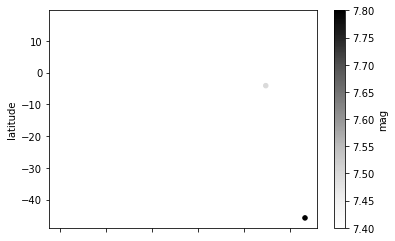

In [11]:
most_severe = df[df.mag >= 7]

%matplotlib inline
most_severe.plot.scatter(x='longitude', y='latitude', c='mag');

Here is the analogous version using `hvplot` where we grab the handle `high_mag_scatter` so we can inspect the return value:

In [12]:
high_mag_scatter = most_severe.hvplot.scatter(x='longitude', y='latitude', c='mag')
high_mag_scatter

:Scatter   [longitude]   (latitude,mag)

As always, this return value is actually a HoloViews element which has a printed representation:

In [13]:
print(high_mag_scatter)

:Scatter   [longitude]   (latitude,mag)


This representation reveals that even though the scatterplot here looks ok, it's actually flawed in a subtle way. Earthquakes occur at a particular 2D longitude, latitude location on the earth's surface and have a measured magnitude, i.e., they are 2D points with some associated value, and should have a representation like "[longitude,latitude] (mag). That is, there should be two key dimensions (independent variables), with the magnitude being a dependent variable ("value dimension"). The problem here is that the Pandas .scatter call makes no distinction between these types of dimensions, which will confuse HoloViews when it is doing automatic linking and other operations that depend on the interpretation of the data. For this purpose, HoloViews provides a separate `.hvplot.points` call that has the same visual representation but the correct semantics:

In [14]:
high_mag_points = most_severe.hvplot.points(x='longitude', y='latitude', c='mag')
high_mag_points

:Points   [longitude,latitude]   (mag)

In [15]:
print(high_mag_points)

:Points   [longitude,latitude]   (mag)


This object now appropriately represents that latitude and longitude are the key dimensions, with one value dimension (the magnitude).

We will learn more about HoloViews objects in the next notebook. But first, let's adjust the options to create a better plot. First we'll use [colorcet](https://colorcet.pyviz.org) to get a colormap that will have a good contrast with blue oceans when we show earthquakes on a map; the default blue colormap above would get lost against the seas! We can choose one from the website and use the HoloViews/Bokeh-based `colorcet` plotting module to make sure it looks good. 

In [16]:
import colorcet as cc
from colorcet.plotting import swatch

swatch('CET_L4')

:Image   [x,y]   (z)

We'll reverse the colors to align dark reds with higher magnitude earthquakes for better contrast.

In [17]:
mag_cmap = cc.CET_L4[::-1]
swatch("CET_L4_r", mag_cmap)

:Image   [x,y]   (z)

In addition to fixing the colormap, we will add some additional columns to the hover text, and add a title.

In [18]:
high_mag_points = most_severe.hvplot.points(
    x='longitude', y='latitude', c='mag', hover_cols=['place', 'time'],
    cmap=mag_cmap,  title='Earthquakes with magnitude >= 7')

high_mag_points

:Points   [longitude,latitude]   (mag,place,time)

When you hover over the points you'll see the place and time of the earthquake in addition to the magnitude and lat/lon. What's displayed by default corresponds to the dimensions that HoloViews is keeping track of, even though not all have been mapped to visible features of the plot:

In [19]:
print(high_mag_points)

:Points   [longitude,latitude]   (mag,place,time)


#### Exercise

Use the colorcet plotting function `swatches(group='linear')` to choose a different colormap and create a plot with it. 


<details><summary><i><u>(Hint)</u></i></summary><br>

```python
from colorcet.plotting import swatches
swatches(group='linear')
```
then    
```python
most_severe.hvplot.points(
    x='longitude', y='latitude', c='mag', hover_cols=['place', 'time'],
    cmap="bgy",  title='Earthquakes with magnitude >= 7')
```

</details>

In [26]:
most_severe.columns

Index(['index', 'depth', 'depthError', 'dmin', 'gap', 'horizontalError', 'id',
       'latitude', 'locationSource', 'longitude', 'mag', 'magError', 'magNst',
       'magSource', 'magType', 'net', 'nst', 'place', 'rms', 'status', 'time',
       'type', 'updated'],
      dtype='object')

### Overlay with a tiled map 

The "CET_L4" colormap works well here, and we can kind of see the outlines of the continents, but the visualization would be much easier to parse if we added a base map underneath. To do this, we'll import a tile element from HoloViews, namely the `OSM` tiles from [openstreetmap](https://www.openstreetmap.org/) using the Web Mercator projection: 

In [20]:
from holoviews.element.tiles import OSM
OSM()

:Tiles   [x,y]

Note that when you zoom, the map becomes more and more detailed, downloading new tiles dynamically as necessary. 

In order to overlay on this basemap, we need to project our earthquakes to the Web Mercator projection system used by Bokeh. This dataset already includes columns for Web Mercator `easting` (meters East of Greenwich) and `northing` (meters north of the equator) columns calculated from `longitude` and `latitude` using the HoloViews [hv.util.transform.lon_lat_to_easting_northing](https://holoviews.org/reference_manual/holoviews.util.html#holoviews.util.transform.lon_lat_to_easting_northing) function, so we'll use those and overlay our points on top of the `OSM` tile source by using the HoloViews `*` operator:

In [28]:
OSM() * most_severe.hvplot.points(
    x='easting', y='northing', c='mag', hover_cols=['place', 'time'], 
    cmap=mag_cmap, title='Earthquakes with magnitude >= 7', line_color='black')

DataError: Supplied data does not contain specified dimensions, the following dimensions were not found: ['easting', 'northing']

PandasInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html

Actually, for this special but common case of overlaying data on geographic tiles, hvPlot lets you simply specify `tiles='OSM'` as a string in the `hvplot.points` call instead of explicitly overlaying a tile source with `*`:

In [ ]:
most_severe.hvplot.points(
    x='easting', y='northing', c='mag', hover_cols=['place', 'time'], 
    cmap=mag_cmap, title='Earthquakes with magnitude >= 7', tiles='OSM',
    line_color='black')

Note that the Web Mercator projection is only one of many possible projections used when working with geospatial data. If you need to work with these different projections, you can use the [GeoViews](http://geoviews.org) extension to HoloViews that makes elements aware of the projection they are defined in and automatically projects into whatever coordinates are needed for display. 


#### Exercise

Import and use different tiles. 


<details><summary><i><u>(Hint)</u></i></summary><br>

Try EsriImagery or Wikipedia.

</details>


### Overlay with a raster
That base map is helpful for orienting ourselves, but it isn't really adding much new information. We might instead like to overlay the earthquakes on other data, such as a map of global population. We'll start by reading in a raster of global population, to see how the events might affect people. We'll use [xarray](https://xarray.pydata.org) to load this multidimensional raster data file, as such formats are not handled well by Pandas. (Luckily, hvPlot supports xarray just as well as Pandas.)

In [30]:
import xarray as xr
import hvplot.xarray  # noqa: adds hvplot method to xarray objects

In [32]:
ds = xr.open_dataarray('data/gpw_v4_population_density_rev11_2010_2pt5_min.nc')
ds

TypeError: Error: C:\Users\jacky\Desktop\Python\dashboard\holoviz-master\examples\tutorial\data\gpw_v4_population_density_rev11_2010_2pt5_min.nc is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            

In [ ]:
cleaned_ds = ds.where(ds.values != ds.nodatavals).sel(band=1)
cleaned_ds.name = 'population'

The `xarray.plot()` Matplotlib API is fine for plotting small sections of this dataset, such as the population of Indonesia:

In [ ]:
ROI = cleaned_ds.sel(y=slice(10, -10), x=slice(90, 110))
ROI.plot();

Matplotlib will struggle with the full dataset, but we can use hvPlot+Datashader to see it all and interactively look at patterns with different spatial scales. Here we will apply a logarithmic colormap to the population counts (similar in appearance to `eq_hist` in this case, but easier for people to interpret), and set a `clim` to exclude the lower bound of zero from the log calculation:

In [ ]:
rasterized_pop = cleaned_ds.hvplot.image(rasterize=True, cnorm='log', clim=(1, np.nan))
rasterized_pop

By inspecting the HoloViews object, we can see that the output isn't actually an Image; instead it is a DynamicMap of Images. This means that any particular image that is displayed is actually just one of many images that are computed on the fly (dynamically), as you can see when you zoom in.

In [ ]:
print(rasterized_pop)

#### Exercise

Use `.last` to inspect the last image from the `DynamicMap`. Zoom into the plot above and inspect `.last` again.

### Putting it together

Now let's overlay the earthquake data on top of the population data, using different colormaps so that we can see both types of data clearly in the same plot.

In [ ]:
title = 'High magnitude (>=7) earthquakes over population density [people/km^2] from 2000 to 2019'

rasterized_pop = cleaned_ds.hvplot.image(
    rasterize=True, cmap='kbc', logz=True, clim=(1, np.nan),
    height=600, width=1000, xaxis=None, yaxis=None
)
high_mag_points = most_severe.hvplot.points(
    x='longitude', y='latitude', c='mag',
    hover_cols=['place', 'time'], cmap=mag_cmap).opts(bgcolor='black') # .opts is described in the next notebook

pop_and_high_mag = (rasterized_pop * high_mag_points).relabel(title)
pop_and_high_mag 

Once again we have used the `*` operator, this time to build an overlay of our earthquake points on top of the population raster.

In [ ]:
print(pop_and_high_mag)

As you can see, the HoloViews objects returned by hvPlot are in no way dead ends -- you can flexibly compare, combine, lay out, and overlay them to reveal complex interrelationships in your data. In fact, this idea of avoiding dead ends is one of the major design principles for HoloViz tools:

<img src="../assets/shortcuts.png" width=70%>

That is, instead of forcing you to choose between a powerful low-level tool that requires extensive expertise even to get started, or a high-level tool that's eventually a dead end, HoloViz tools try to provide you a quick way to get to something that is at least _nearly_ what you want, while making it possible to further customize and tweak what you get so that the end result can be precisely what you want. That way you only need to learn the specific low-level bits actually required, whether that's at the HoloViews level (if you need to customize your hvPlot-generated objects), or further down to Bokeh and JavaScript.

In the next notebook we'll learn how to link up the HoloViews plots you've generated, to help you understand the relationships between the various views of your data that you create.